In [1]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import torch.nn as nn
from torch.utils.data import DataLoader
import soundfile as sf

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

eps = 1e-5

### Creating W from single note audio files

In [2]:
single_note = "test-data/single-notes"

In [3]:
W, freqs, sample_rate, freqs_true = init.init_W(single_note, avg_size=30)
W_max = spec.max_columns(W)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


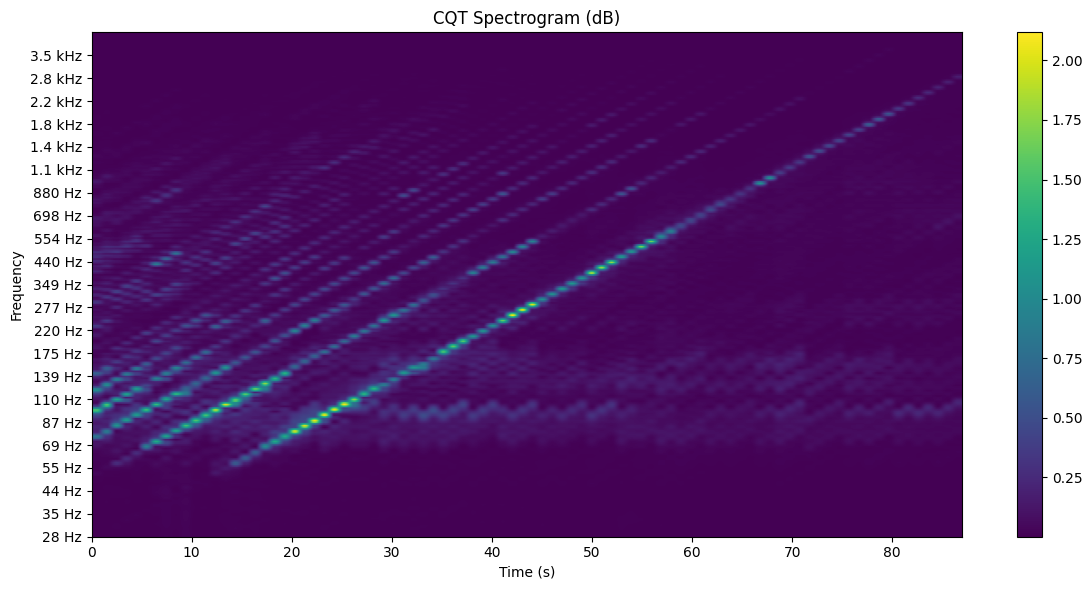

In [4]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs_true, 0, W.shape[1])

In [5]:
y, sr = torchaudio.load("test-data/single-notes/C1.wav")

# spec_cqt = np.abs(librosa.stft(y.numpy(), hop_length=512))
y = y.numpy()
stft = np.abs(librosa.stft(np.mean(y, axis=0), n_fft=1024, hop_length=512))
f0 = torchyin.estimate(y, sr, pitch_max=5000)
f = f0[0, init.first_non_zero(f0[0])]
f
# librosa.display.specshow(W[:,:].numpy(), y_axis='cqt_hz', fmin=librosa.note_to_hz('A0'), sr=sample_rate, bins_per_octave=36, hop_length=128)

tensor([32.8093])

In [ ]:
y, sr = torchaudio.load("reconstructed_audio.wav")
f0 = torchyin.estimate(y, sr, pitch_max=5000)
f0

In [ ]:
import soundfile as sf

reconstructed_audio = librosa.griffinlim(stft[:,init.first_non_zero(f0[0])-1:init.first_non_zero(f0[0])], hop_length=512, n_iter=32)
# reconstructed_audio = librosa.griffinlim(spec_cqt[0,:,:], hop_length=512, n_iter=32)
sf.write('reconstructed_audio.wav', reconstructed_audio, sr)
# plt.plot(reconstructed_audio)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=0
  warnings.warn(


### Running MU iterations on a simple example from init W

In [5]:
waveform_test, sample_rate_test = torchaudio.load("dataset/audios/test-midi-transcription.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)

# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])
midi, times = spec.midi_to_pianoroll("dataset/midis/test-midi-transcription.mid", waveform_test, times_test, hop_length=128)
onset, offset = utils.detect_onset_offset(midi)

In [6]:
f, t = cqt_test.shape
l = W.shape[1]
n_init_steps = 100

H = init.init_H(l, t, W, cqt_test, n_init_steps, beta=1)

#### Reconstructing the CQT from W and H:

In [ ]:
M_hat = W @ H
# spec.vis_cqt_spectrogram(M_hat, times_test, freq_test, 0, times_test[-1])
# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])


In [ ]:
cqt_test.mean()

tensor(0.0593)

In [ ]:
l = nn.MSELoss()
loss = l(M_hat, cqt_test)
diff = M_hat - cqt_test
loss

tensor(0.0155)

### Retrieving frequencies and notes from W

In [ ]:
W0 = W[:,0]
def find_fundamental_frequency(cqt_column, freqs, avg_size=10):
    # Ensure cqt_column is a PyTorch tensor
    if not isinstance(cqt_column, torch.Tensor):
        cqt_column = torch.tensor(cqt_column)

    # Convert freqs to a tensor if it's not already
    if not isinstance(freqs, torch.Tensor):
        freqs = torch.tensor(freqs)

    # Harmonic summation
    harmonic_sum = torch.zeros(len(freqs))
    for i in range(len(freqs)):
        # Calculate harmonic frequencies
        harmonic_freqs = freqs[i] * torch.arange(1, 10, dtype=torch.float32)  # Consider up to the 9th harmonic
        for hf in harmonic_freqs:
            if hf < freqs[-1]:
                # Find the closest frequency bin
                idx = torch.argmin(torch.abs(freqs - hf))
                harmonic_sum[i] += cqt_column[idx]

    # Find the fundamental frequency
    fundamental_idx = torch.argmax(harmonic_sum)
    fundamental_freq = freqs[fundamental_idx]

    return fundamental_freq.item()

In [ ]:
freq = find_fundamental_frequency(W0, freqs, avg_size=5)
freq

233.0818634033203

In [7]:
pitches, notes, W, H = init.W_to_pitch(W, freqs_true, H=H)
print(notes, len(notes))

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87.]) 88


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


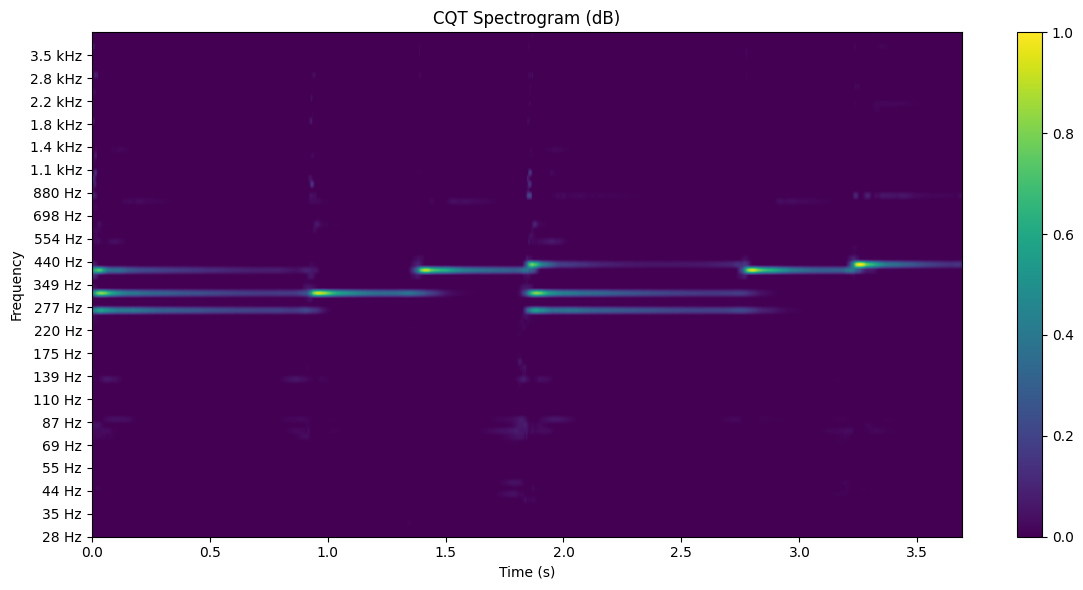

In [8]:
spec.vis_cqt_spectrogram(H, times_test, pitches, 0, 4)

### Retrieving MIDI from W and H

In [9]:
midi_hat, active_midi = init.WH_to_MIDI(W, H, notes, threshold=0.02, smoothing_window=5, adaptative=False, normalize=True)
active_midi

[39, 42, 46, 47]

In [10]:
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
active_midi

[39, 42, 46, 47]

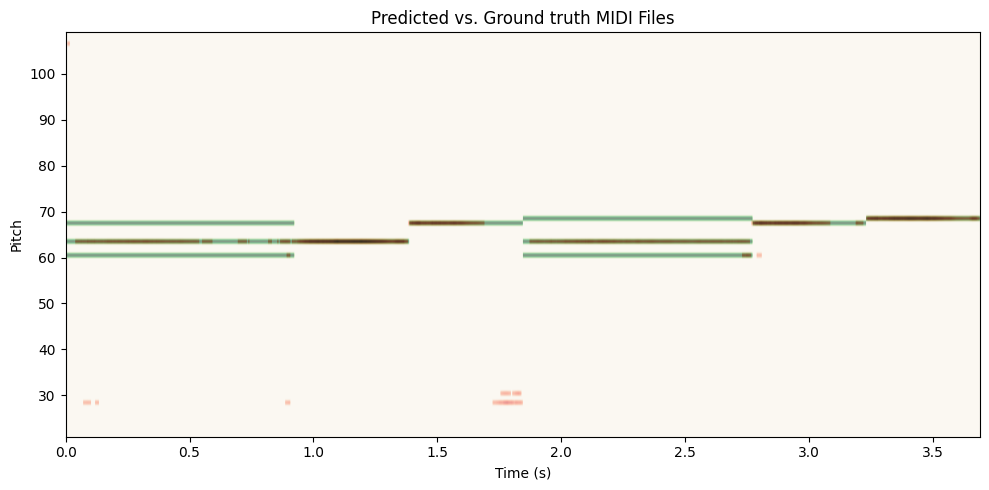

In [11]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

In [12]:
criterion = nn.BCELoss()
loss = criterion(midi_hat[active_midi,:], midi[active_midi,:])
loss

tensor(28.6804)

### MIDI reconstruction

In [20]:
midi_hat, active_midi = init.WH_to_MIDI(W, H, notes, threshold=0.02, smoothing_window=5, adaptative=False, normalize=True)
active_midi

[39, 42, 46, 47]

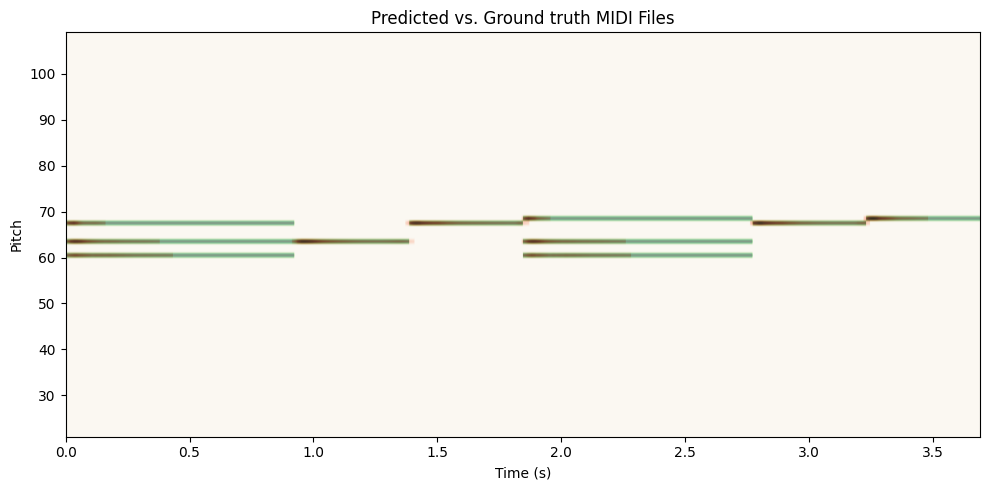

In [21]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

### Training

In [34]:
model = models.RALMU2(l, eps, beta=1, W_path=single_note, n_iter=5, shared=True)
device  = torch.device('cpu')
model.to(device=device)
dataset = utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for M, midi_batch in loader:
    model.init_WH(M)
    M = M.to(device)
    midi_batch = midi_batch.to(device)

    W_hat, H_hat, M_hat = model(M)
    # W_hat, H_hat, M_hat = model.W0, model.H0, M
    _, notes, _, _ = init.W_to_pitch(W_hat, model.freqs, H=H_hat)
    midi_hat, active_midi_hat = init.WH_to_MIDI(W_hat, H_hat, notes, threshold=0.02, smoothing_window=5, adaptative=False, normalize=True)
    # M_hat = M_hat.squeeze(0)
    midi_batch = midi_batch.squeeze(0)
    active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
    # print(len(active_midi), len(active_midi_hat))
    # spec.compare_midi(midi, midi_hat, times_test, 0, times_test[-1])
    optimizer.zero_grad()
    loss = criterion(midi_hat[active_midi,:], midi_batch[active_midi,:])
    print(loss)
    loss.backward()
    for param in model.parameters():
        if param.grad is not None:
            print(f"Grad norm: {param.grad.norm().item()}")
        else:
            print(f"Grad is None for {param}")
    optimizer.step()
                    
    print("------------ Next audio file... ------------")

Initialized W and H from files torch.Size([88, 4575]) torch.Size([288, 88])
Cached W and H
tensor(12.2420, grad_fn=<BinaryCrossEntropyBackward0>)
Grad norm: 1.7937554730451666e-06
Grad norm: 5.918045644648373e-06
Grad norm: 2.6625502869137563e-05
Grad norm: 9.2546497398871e-06
Grad norm: 1.432004773960216e-05
Grad norm: 1.5129006897041108e-05
Grad norm: 0.0019823266193270683
Grad norm: 5.140208941156743e-06
Grad norm: 0.008480633608996868
Grad norm: 7.049432952044299e-06
Grad norm: 0.0017975830705836415
Grad norm: 4.073182026331779e-06
------------ Next audio file... ------------
Initialized W and H from files torch.Size([88, 1385]) torch.Size([288, 88])
Cached W and H
tensor(47.1186, grad_fn=<BinaryCrossEntropyBackward0>)
Grad norm: 1.0974304132105317e-05
Grad norm: 1.3980335097585339e-05
Grad norm: 8.783285738900304e-05
Grad norm: 2.551658690208569e-05
Grad norm: 0.00011450792953837663
Grad norm: 5.579800563282333e-05
Grad norm: 0.0003480160085018724
Grad norm: 1.7088714230339974e-05

In [16]:
loss = utils.loss_midi(midi_hat, midi)
loss

tensor(2078.7217)

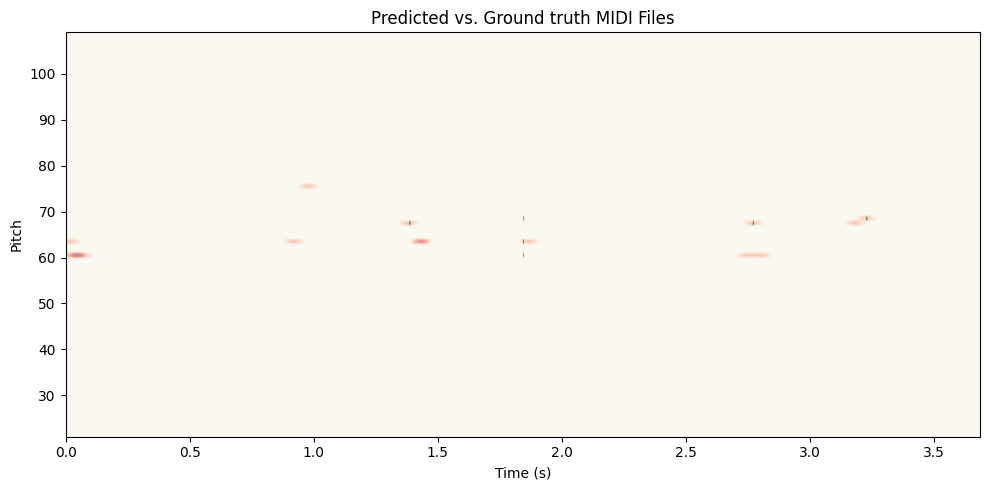

In [12]:
onset_hat, offset_hat = utils.detect_onset_offset(midi_hat, filter=True)
spec.compare_midi(onset,onset_hat, times_test, 0, times_test[-1])

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

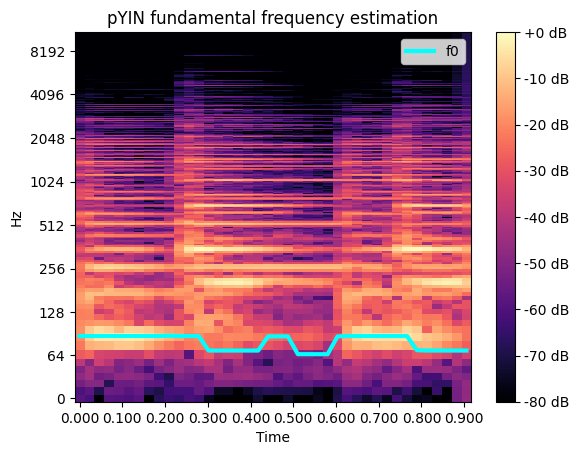

In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')